<a href="https://colab.research.google.com/github/tayfununal/Uniform-Autoencoder-with-Latent-Flow-Matching/blob/main/UAE-with-LFM/generation/cifar10_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/tayfununal/Uniform-Autoencoder-with-Latent-Flow-Matching.git

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torch.nn.functional as F
from torch import Tensor

from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

import os

print(os.getcwd())

%run /content/Uniform-Autoencoder-with-Latent-Flow-Matching/models/cifar10_model.ipynb
%run /content/Uniform-Autoencoder-with-Latent-Flow-Matching/datasets/cifar10_dataset.ipynb

# Flow Matching Model
%run /content/Uniform-Autoencoder-with-Latent-Flow-Matching/UAE-with-LFM/models/cifar10_flow_model.ipynb

plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

In [ ]:
# Dataset
test_dataset = CIFAR10Dataset(mode='test')
# DataLoader
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [ ]:
# Load the UAE model

path = '/content/Uniform-Autoencoder-with-Latent-Flow-Matching/results/cifar-10/UAE_Cifar_10'
model = torch.load(path + '.model', weights_only=False, map_location='cpu')
model.eval()

To_Uniform(
  (encoder): SimpleEncoder(
    (conv1): Conv2d(3, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(256, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): ReLU()
      (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Linear(in_features=512, out_features=256, bias=True)
      (4): 

In [ ]:
# Create the "results" folder
os.makedirs("results", exist_ok=True)

flow_name = '/content/Uniform-Autoencoder-with-Latent-Flow-Matching/UAE-with-LFM/results/cifar10/UAE_Latent_FM'
flow = torch.load(flow_name + '.model', weights_only=False, map_location='cpu')
flow.eval()

Flow(
  (net): Sequential(
    (0): Linear(in_features=257, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=1000, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1000, out_features=1000, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1000, out_features=1000, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1000, out_features=1000, bias=True)
    (9): ReLU()
    (10): Linear(in_features=1000, out_features=1000, bias=True)
    (11): ReLU()
    (12): Linear(in_features=1000, out_features=1000, bias=True)
    (13): ReLU()
    (14): Linear(in_features=1000, out_features=256, bias=True)
  )
)

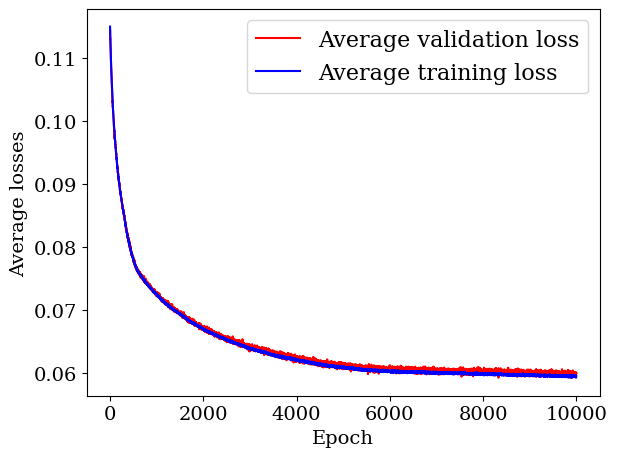

In [ ]:
# Load the losses
losses = np.loadtxt("/content/Uniform-Autoencoder-with-Latent-Flow-Matching/UAE-with-LFM/results/cifar10/losses.csv", delimiter=",", skiprows=1)
train_losses = losses[:, 0]
val_losses = losses[:, 1]

# Create a plot
plt.plot(val_losses, label="Average validation loss", c="red")
plt.plot(train_losses, label="Average training loss", c="blue")

plt.xlabel("Epoch")
plt.ylabel("Average losses")
plt.legend(loc='upper right', fontsize=16)

plt.tight_layout()
plt.savefig("/content/Uniform-Autoencoder-with-Latent-Flow-Matching/UAE-with-LFM/results/cifar10/average_losses_per_epoch.pdf")
plt.show()

In [ ]:
# Initialize uniform random data (3D)
x_uniform = torch.rand(len(test_dataset), 256)
n_steps = 8

# Create time steps
time_steps = torch.linspace(0, 1.0, n_steps + 1)


for i in range(n_steps):
    x_uniform = flow.step(x_t=x_uniform, t_start=time_steps[i], t_end=time_steps[i + 1])

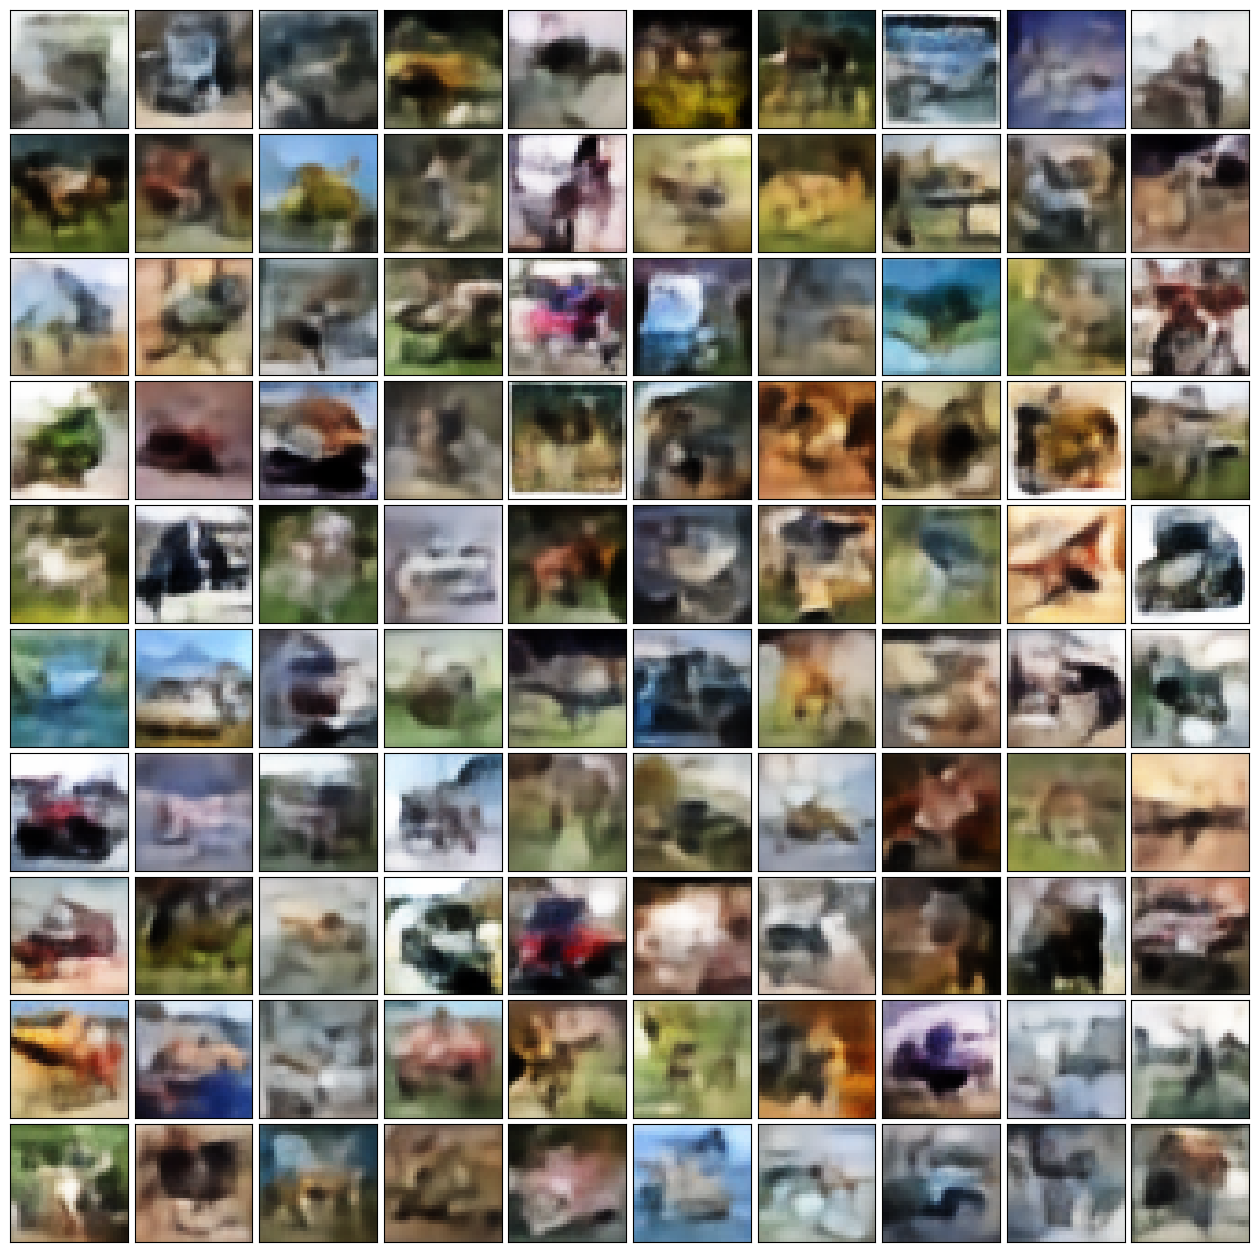

In [ ]:
# Decode
x_hat = model.decoder(x_uniform).view(-1, 3, 32, 32)

# Plot
fig, axs = plt.subplots(10, 10, figsize=(16, 16), sharex=True, sharey=True,
                        subplot_kw={'xticks': [], 'yticks': []},
                        gridspec_kw=dict(hspace=0.05, wspace=0.05))

for i, ax in enumerate(axs.flat):
    img = x_hat[i].reshape(3, 32, 32).permute(1, 2, 0).detach().numpy()
    ax.imshow(img, interpolation='nearest')

plt.savefig('/content/Uniform-Autoencoder-with-Latent-Flow-Matching/UAE-with-LFM/results/cifar10/cifar10_veri_uretimi_from_latent_FM.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1, dpi=300)
plt.show()